Downloading the data:

In [ ]:
!wget gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
!unzip DL1920-assignment3-data.zip

--2020-05-31 19:20:47--  http://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
Resolving gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)... 193.0.96.2, 2001:6a0:5001::3
Connecting to gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)|193.0.96.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip [following]
--2020-05-31 19:20:48--  https://gsn.mimuw.edu.pl/DL1920-assignment3-data.zip
Connecting to gsn.mimuw.edu.pl (gsn.mimuw.edu.pl)|193.0.96.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45714 (45K) [application/zip]
Saving to: ‘DL1920-assignment3-data.zip’

DL1920-assignment3- 100%[===================>]  44.64K   143KB/s    in 0.3s    

2020-05-31 19:20:50 (143 KB/s) - ‘DL1920-assignment3-data.zip’ saved [45714/45714]

Archive:  DL1920-assignment3-data.zip
  inflating: test_y.csv              
  inflating: train_y.csv             
  inflating: test_x.csv              
  inflating: train_x.csv   

Imports and laoding data, as we can se there are 9000 train samples and 1000 test samples.

In [ ]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import random
from matplotlib import animation, rc
from IPython.display import HTML

b_size = 20
num_epochs = 25
device = torch.device('cuda')

x_train = pd.read_csv('train_x.csv', header=None)
y_train = pd.read_csv('train_y.csv', header=None)
x_test = pd.read_csv('test_x.csv', header=None)
y_test = pd.read_csv('test_y.csv', header=None)
print(x_train.shape)
print(x_test.shape)

(9000, 5)
(1000, 5)


Converting pandas dataframes to numpy arrays:

In [ ]:
def pandas_to_numpy(df):
  len = df.shape[0]
  nump = np.zeros((len, 5, 2))
  for i in range(len):
    for j in range(5):
      str = df.iat[i, j]
      nump[i][j][0] = int(str[0])
      nump[i][j][1] = int(str[2])
  
  return nump
    
x_train_np = pandas_to_numpy(x_train)
x_test_np = pandas_to_numpy(x_test)
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

y_train_np = np.squeeze(y_train_np)
y_test_np = np.squeeze(y_test_np)

print(x_train_np.shape, y_train_np.shape)

(9000, 5, 2) (9000,)


Task 3.1 - Visualization.

The code below visualizes some paths from the data set (one can change the number of visualized paths by changing plot functions argument. 

I used different colours (yellow, blue, green and red) for time series belonging to different classes. 

Each two consecutive points are connected with a line and I coloured first point with black and last point with cyan so one can recognize the order of points in time series. 

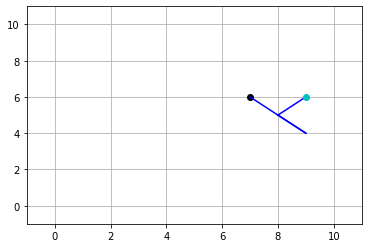

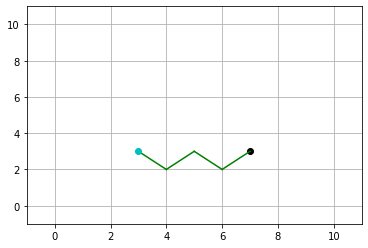

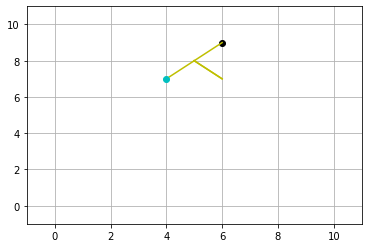

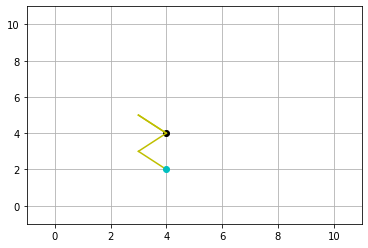

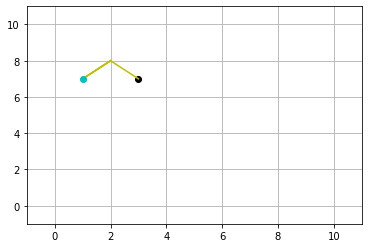

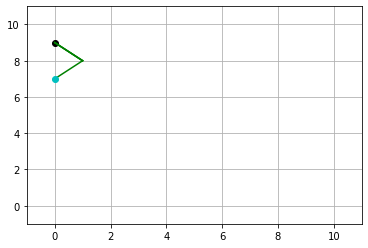

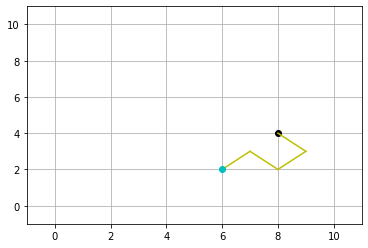

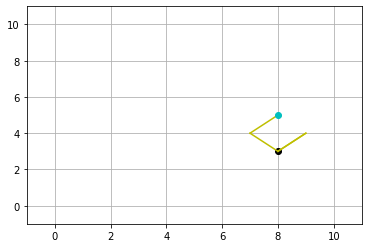

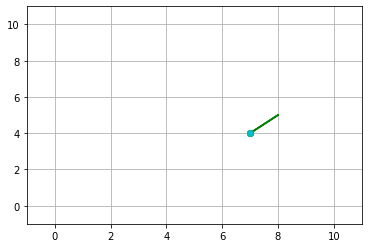

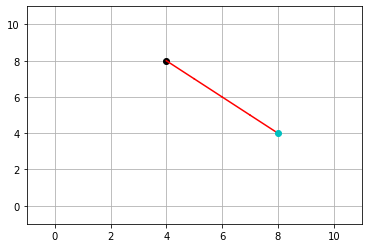

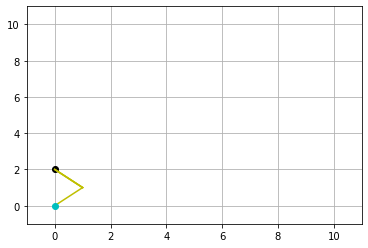

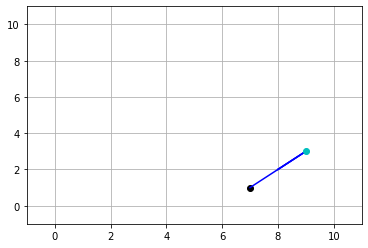

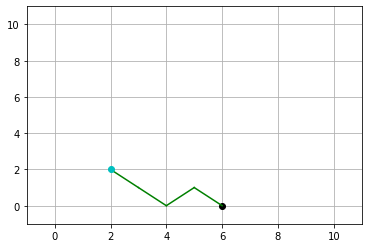

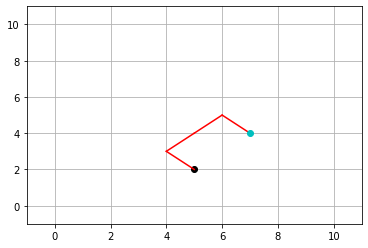

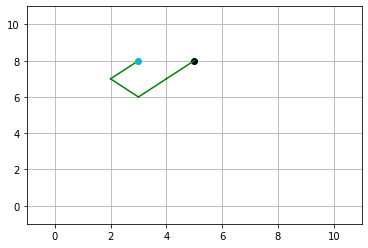

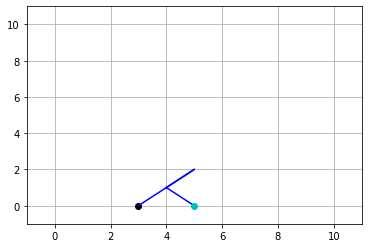

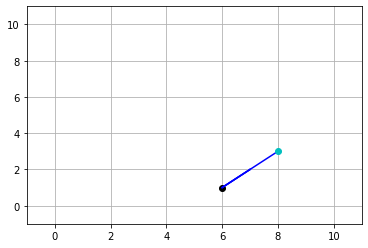

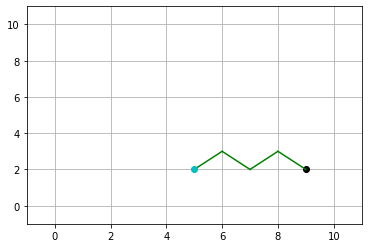

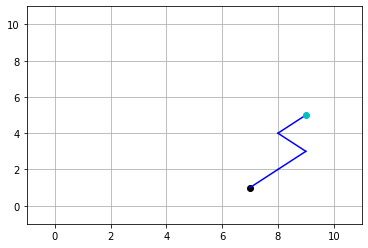

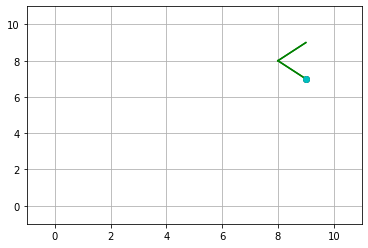

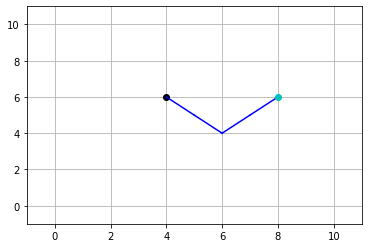

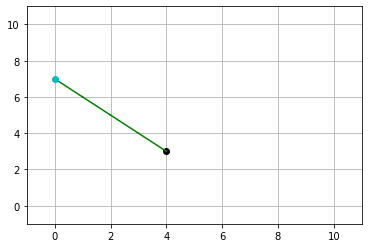

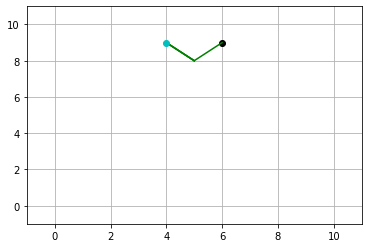

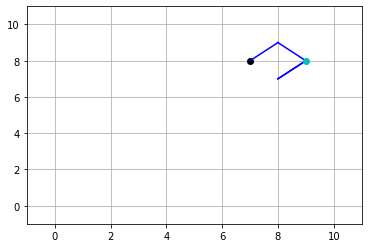

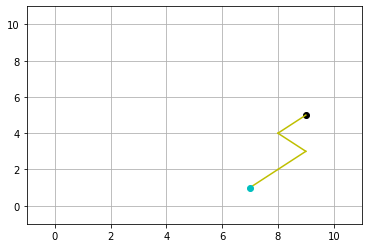

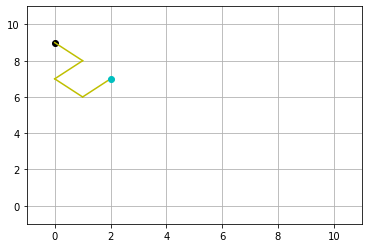

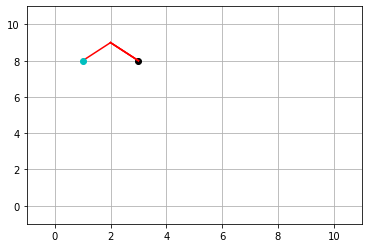

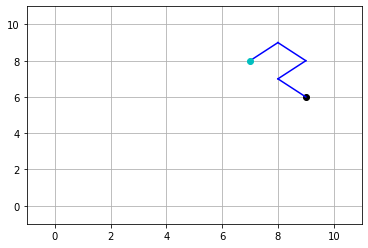

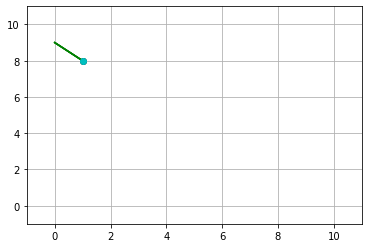

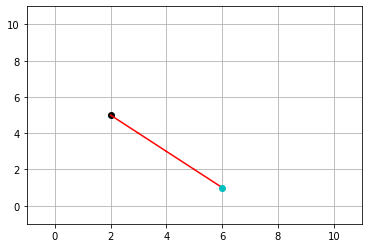

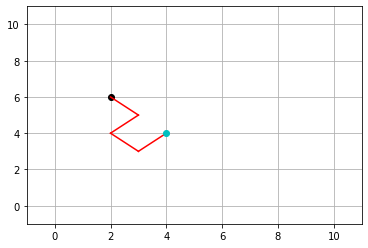

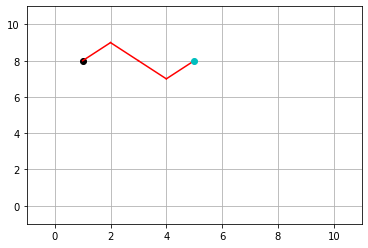

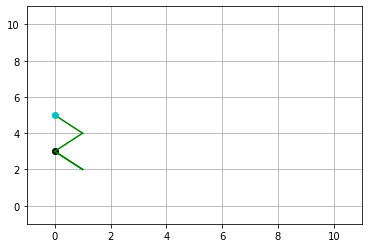

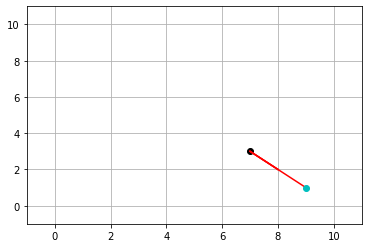

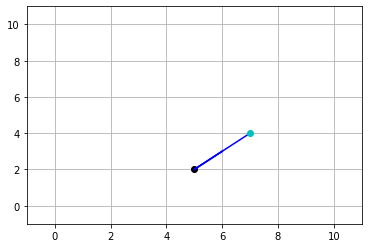

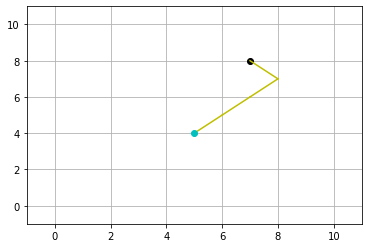

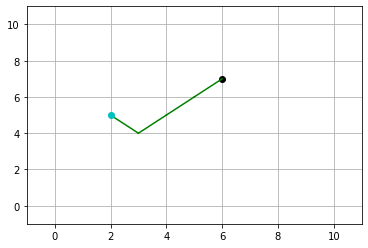

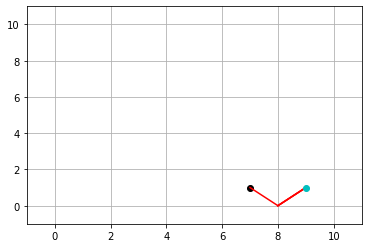

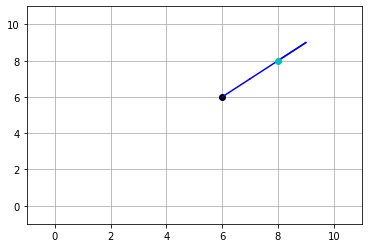

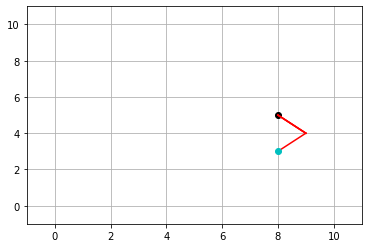

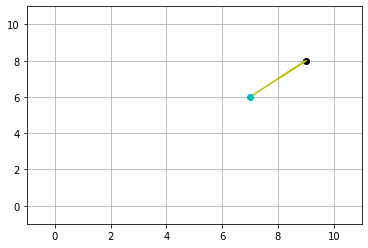

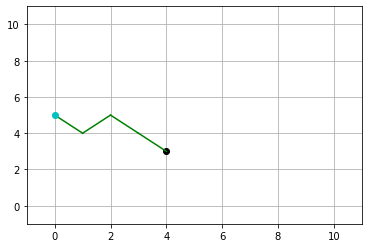

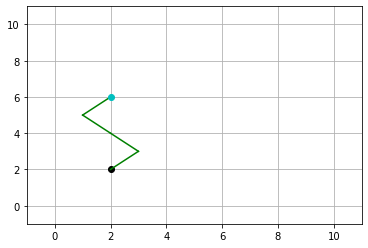

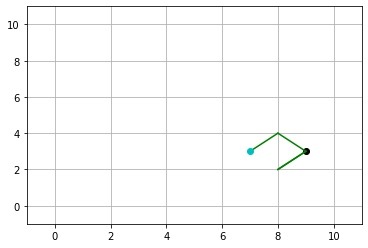

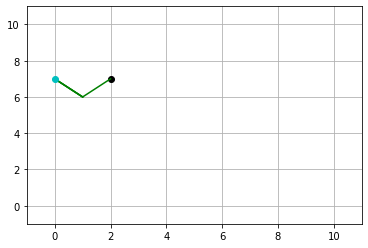

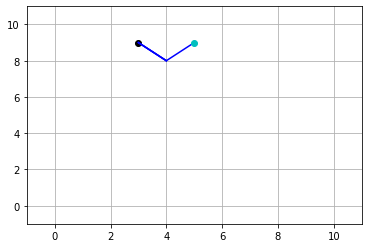

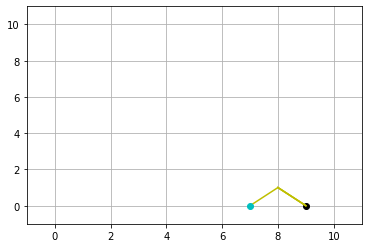

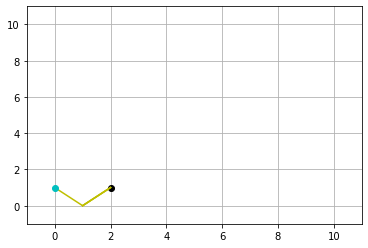

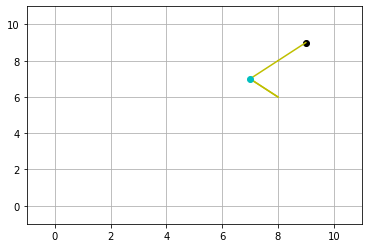

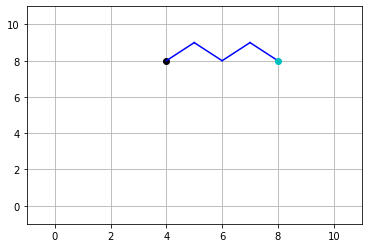

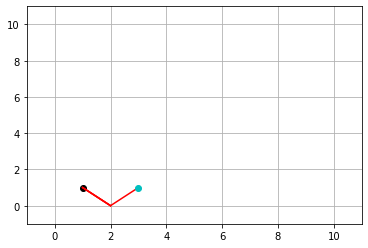

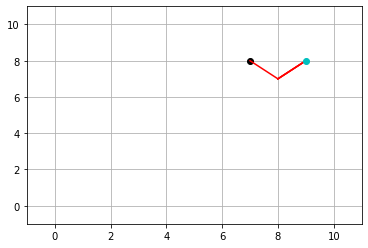

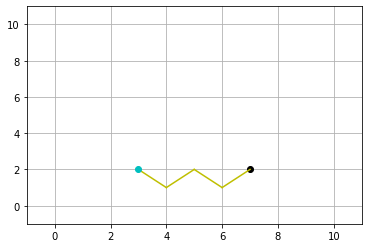

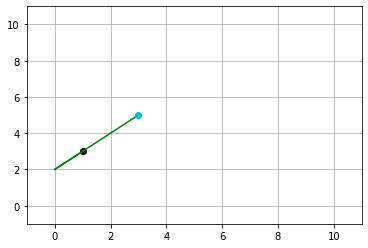

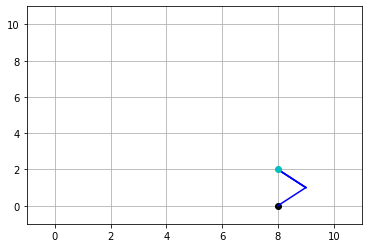

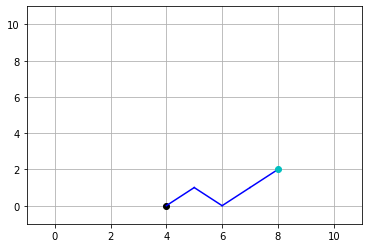

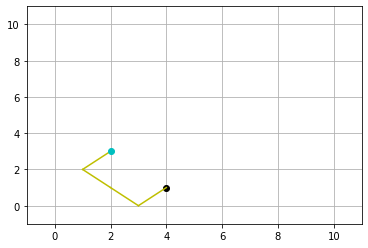

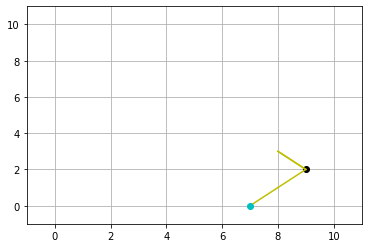

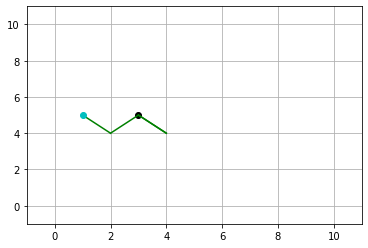

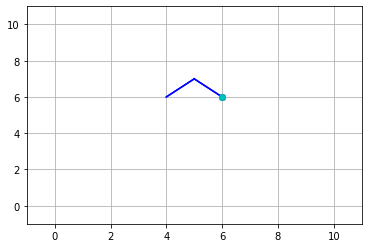

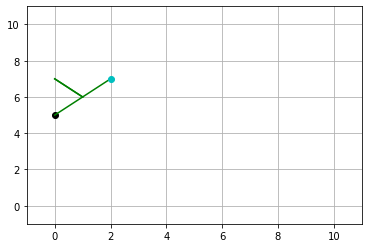

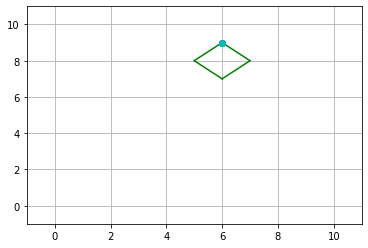

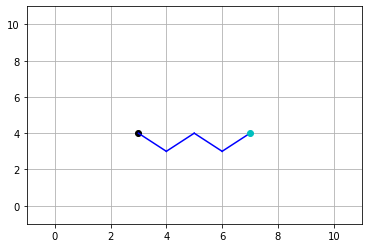

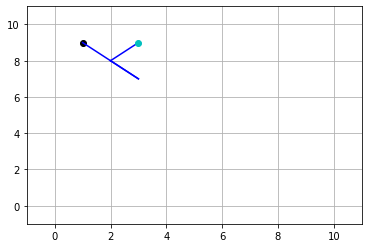

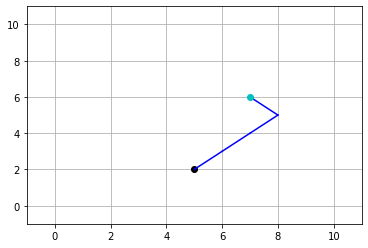

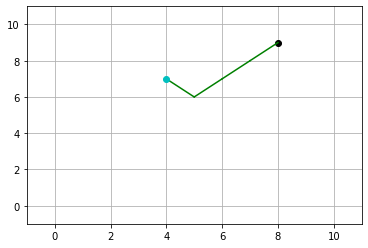

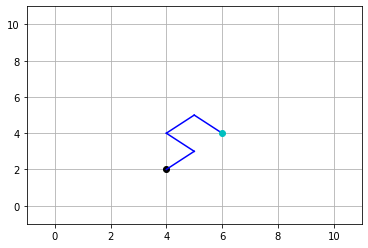

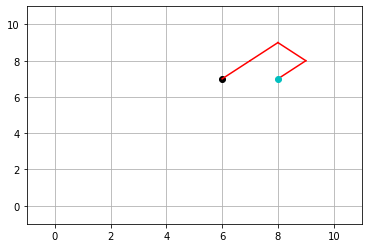

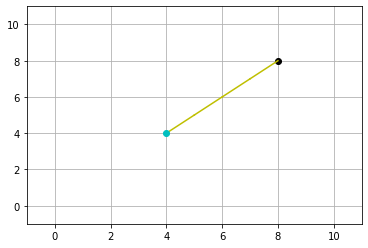

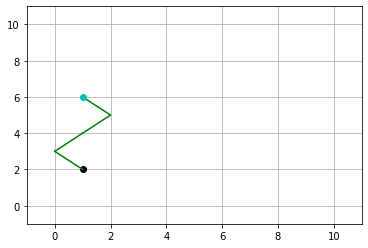

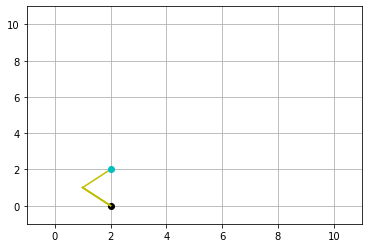

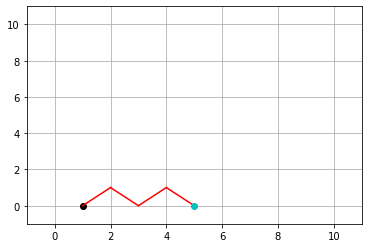

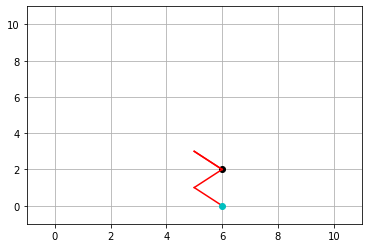

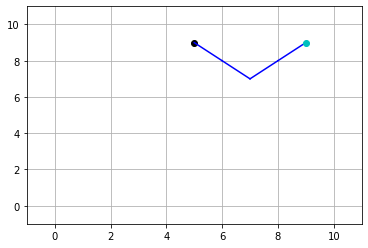

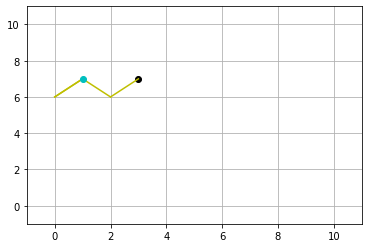

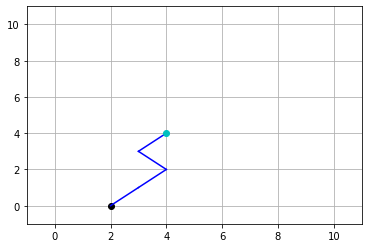

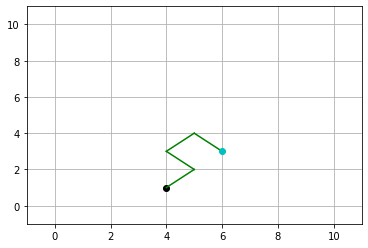

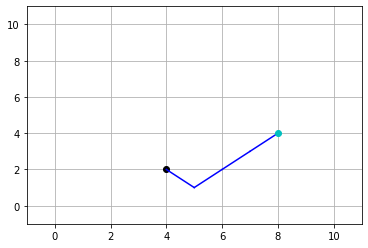

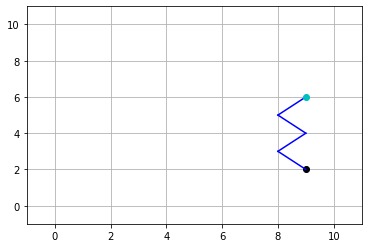

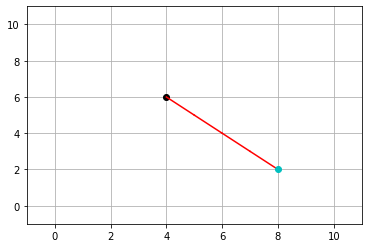

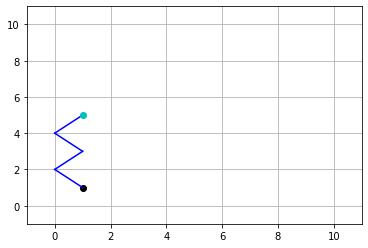

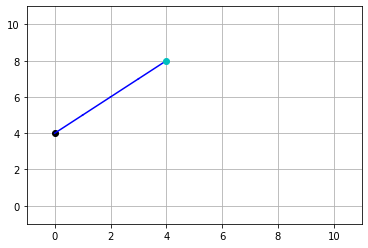

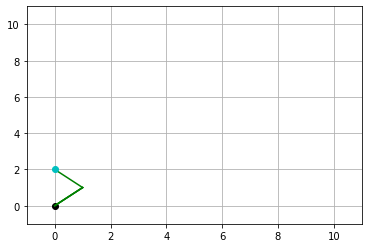

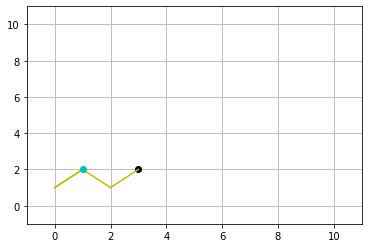

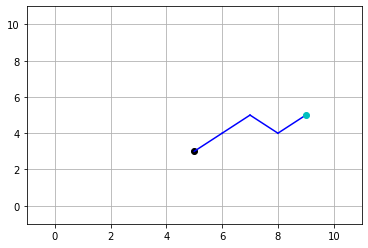

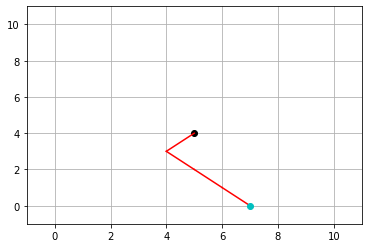

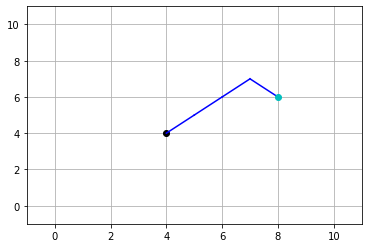

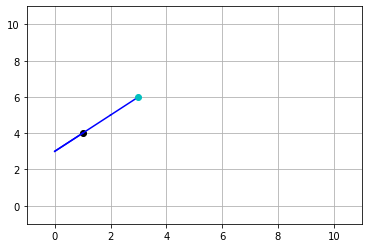

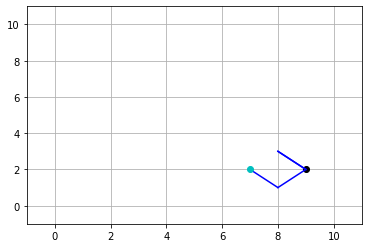

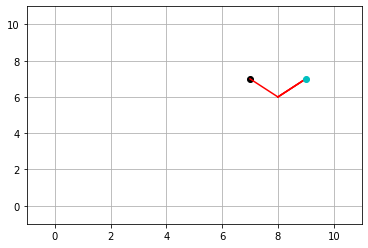

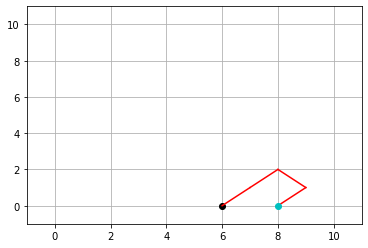

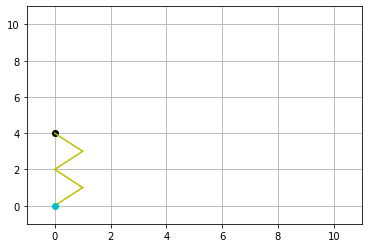

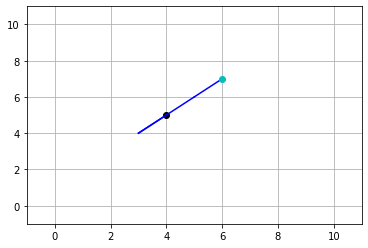

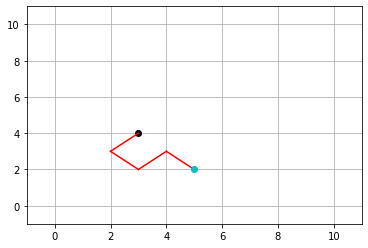

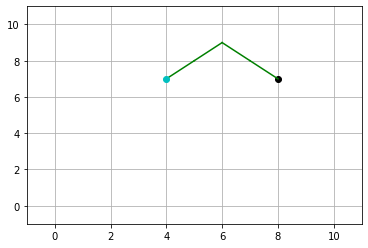

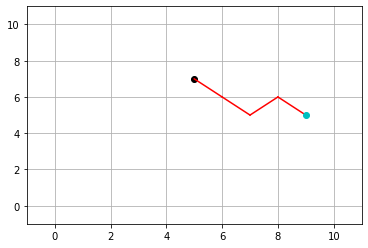

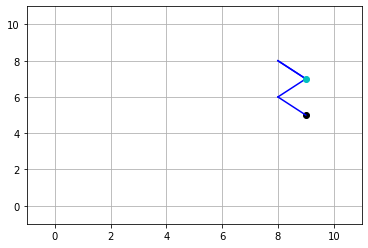

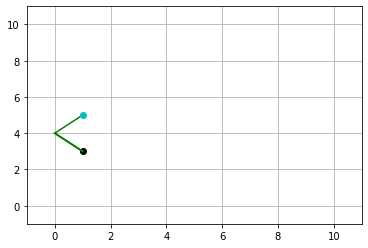

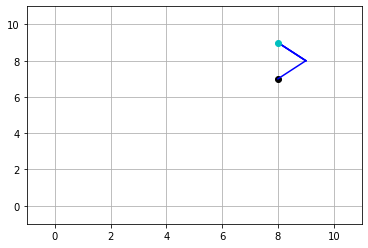

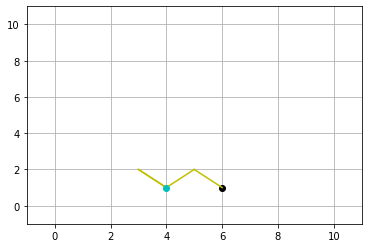

In [ ]:
def get_color(labels, idx):
  res = labels[idx]
  line = ''
  if (res == 0):
    line = 'b-'
  elif (res == 1):
    line = 'g-' 
  elif (res == 2):
    line = 'r-'
  else:
    line = 'y-'

  return line

def plot(xs, ys, num):
  for i in range (num):
    axes = plt.gca()
    axes.set_xlim([-1,11])
    axes.set_ylim([-1,11])
    line = get_color(ys, i)

    plt.plot(xs[i][0][0], xs[i][0][1], 'ko-')

    for j in range(4):
      plt.plot([xs[i][j][0], xs[i][j+1][0]], [xs[i][j][1], xs[i][j+1][1]], line)

    plt.plot(xs[i][4][0], xs[i][4][1], 'co-')

    plt.grid(True)
    plt.show()

plot(x_train_np, y_train_np, 100)

After having a close look at the paths one can see that paths from diffrent classes tend to go "on average" to different corners of the grid. Let's verify this. In the code below I meassure average shift for paths of each colour along each dimension. The results show that paths of each class make an average vertical and horizontal shift of length ~1.45 with the direction depending on the color of path. Therefore it looks like in each step the direction of move is chosen with some fixed probability. My quick calculation suggest, that probability for more common direction is about 2/3, but it does not take into accout the fact that the direction is determined when path approaches boundary, so it's probably a bit higher (i would guess 65-70%).

In [ ]:
def avg(l):
  return sum(l) / len(l)

diffsx = [[],[],[],[]]
diffsy = [[],[],[],[]]
avgx = []
avgy = []

for i in range (x_train_np.shape[0]):
  cls = y_train_np[i]
  diffsx[cls].append(x_train_np[i][4][0] - x_train_np[i][0][0])
  diffsy[cls].append(x_train_np[i][4][1] - x_train_np[i][0][1])

for i in range(4):
  avgx.append(avg(diffsx[i]))
  avgy.append(avg(diffsy[i]))

print(avgx)
print(avgy)

[1.3777585460839463, -1.4577777777777778, 1.4101174345076783, -1.4876404494382023]
[1.4054521852012116, 1.4986666666666666, -1.4019873532068654, -1.4408988764044943]


Packed dataset converts data into pytorch tensors. If one chooses to truncate data then the transform method randomly chooses 50% of time series and replaces last point with padding (padding value is 100 because it is the least value that will not occur in dataset). 

Below there are also functions that get lengths of time series from padded tensor and perform packing/unpacking neccessary for training LSTM with samples of variable length.

In [ ]:
class PackedDataset(torch.utils.data.Dataset):
  def __init__(self, paths, labels, truncate, embed):
    self.paths = paths
    self.labels = labels
    self.len = self.paths.shape[0]
    self.truncate = truncate
    self.embed = embed

  def transform(self, path):
    if (self.embed):
      # clone to avoid changing numpy arrays with data.
      res = np.copy(10 * path[:,0] + path[:,1])
      res = torch.from_numpy(res)
      # Randomly choose 50% of samples and remove last element and pad it with [100, 100]
      if(self.truncate):
        if(random() > 0.5):
          res[-1] = 100

      return res.type(torch.LongTensor)

    else:
      # clone to avoid changing numpy arrays with data.
      res = torch.from_numpy(path).clone()
      # Randomly choose 50% of samples and remove last element and pad it with [100, 100]
      if (self.truncate):
        if(random() > 0.5):
          res[-1] = torch.Tensor([100,100])

      return res

  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    trans = self.transform(path)
    return trans, label

  def __len__(self):
    return self.len
    
def get_lens(batch, embed=False):
  lengths = torch.zeros(b_size)

  if embed:
    for i in range(b_size):
      if batch[i][4] == 100:
        lengths[i] = 4
      else:
        lengths[i] = 5

  else:
    for i in range(b_size):
      if batch[i][4][0] == 100:
        lengths[i] = 4
      else:
        lengths[i] = 5

  return lengths

def pack_batch(batch, lengths):
  return torch.nn.utils.rnn.pack_padded_sequence(batch, lengths, batch_first=True, enforce_sorted=False)

def unpack_batch(packed):
  return torch.nn.utils.rnn.pad_packed_sequence(packed, batch_first=True, padding_value=-1)

3.2 Model on raw data.

For this task I used simple neural net with LSTM and linear layer. Firstly, the input tensor is packed, then passed through LSTM network. After unpacking we extract the last LSTM output for each time series and pass it through linear layer. The hidden size of LSTM layer will be set to 100. Cross Entropy is used as loss function. 


In [ ]:
class MyLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MyLSTM, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

    self.c0 = torch.zeros(1,b_size,self.hidden_size, device=device)
    self.h0 = torch.zeros(1,b_size,self.hidden_size, device=device)
    self.hidden = (self.c0, self.h0)

  def forward(self, x, lens):
    x = pack_batch(x, lens)
    x, _= self.lstm(x.float(), self.hidden)
    # shape of x: (batch_size, seq_len, hidden_size)
    x , lens = unpack_batch(x)
    # take last output from LSTM and pass it through linear layer
    # shape of y: (batch_size, hidden_size)
    y = torch.zeros(b_size, self.hidden_size, device=device)
    for i in range(b_size):
      y[i] = x[i][lens[i] - 1]

    y = self.linear(y)
    
    return y

criterion  = nn.CrossEntropyLoss()

The variables introduced below are used to collect information from training neccessary for visualization in the last task.

In [ ]:
visualData = PackedDataset(x_train_np, y_train_np, truncate=False, embed=True)
visualloader = torch.utils.data.DataLoader(visualData, batch_size=b_size, shuffle=False, num_workers=0)
dataiter = iter(visualloader)
visual_paths, visual_labels = dataiter.next()
visual_paths = visual_paths.cuda()
embed_evolution = []

During training, after each 1000 steps the loss is evaluated and printed. After each epoch the model is evaluated on validation set and embedding of sample input is collected for visualization purposes.

In [ ]:
def train_epoch(net, trainloader, embed):
  optimizer = torch.optim.Adam(net.parameters())
  running_loss = 0.0
  if (embed):
    visual_embedding = net.get_embedding(visual_paths)
    embed_evolution.append(visual_embedding.cpu())
  
  for i, data in enumerate(trainloader, 0):
    paths, labels = data
    lens = get_lens(paths, embed=embed)
    
    # lens = lens.cuda()
    paths = paths.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    outputs = net(paths, lens)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if (i * b_size % 1000 < b_size and i > 0): 
      loss_per_batch = running_loss * b_size / 1000
      print('step %d loss: %.3f' %
            (i * b_size, loss_per_batch))
      running_loss = 0.0

def validation(net, validloader, embed):
  total = 0
  correct = 0
  with torch.no_grad():
    for data in validloader:
      paths, labels = data
      lens = get_lens(paths, embed=embed)
      
      # lens = lens.cuda()
      paths = paths.cuda()
      labels = labels.cuda()

      outputs = net(paths, lens)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total

  print('Accuracy on validation set: %.2f %%' % (accuracy))

The model is first trained for one epoch on truncated data. After that it is trained for 5 epochs on original data. We do not need more epochs since the model quickly reaches accuracy of 65-70% and then the results saturate.

In [ ]:
my_lstm = MyLSTM(2, 100, 4)
my_lstm = my_lstm.cuda()

trainset = PackedDataset(x_train_np, y_train_np, truncate=True, embed=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=0)

validset = PackedDataset(x_test_np, y_test_np, truncate=True, embed=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=False, num_workers=0)

print('Epoch with truncated samples')
train_epoch(net=my_lstm, trainloader=trainloader, embed=False)
validation(net=my_lstm, validloader=validloader, embed=False)

trainset = PackedDataset(x_train_np, y_train_np, truncate=False, embed=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=0)

validset = PackedDataset(x_test_np, y_test_np, truncate=False, embed=False)
validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=False, num_workers=0)

for i in range(5):
  print('Epoch: ', i + 1)
  train_epoch(net=my_lstm, trainloader=trainloader, embed=False)
  validation(net=my_lstm, validloader=validloader, embed=False)

Epoch with truncated samples
step 1000 loss: 1.355
step 2000 loss: 1.232
step 3000 loss: 1.091
step 4000 loss: 0.996
step 5000 loss: 0.951
step 6000 loss: 0.935
step 7000 loss: 0.969
step 8000 loss: 0.957
Accuracy on validation set: 59.90 %
Epoch:  1
step 1000 loss: 0.833
step 2000 loss: 0.762
step 3000 loss: 0.835
step 4000 loss: 0.769
step 5000 loss: 0.800
step 6000 loss: 0.792
step 7000 loss: 0.760
step 8000 loss: 0.782
Accuracy on validation set: 66.50 %
Epoch:  2
step 1000 loss: 0.805
step 2000 loss: 0.764
step 3000 loss: 0.774
step 4000 loss: 0.796
step 5000 loss: 0.837
step 6000 loss: 0.718
step 7000 loss: 0.751
step 8000 loss: 0.745
Accuracy on validation set: 68.40 %
Epoch:  3
step 1000 loss: 0.811
step 2000 loss: 0.787
step 3000 loss: 0.758
step 4000 loss: 0.760
step 5000 loss: 0.769
step 6000 loss: 0.801
step 7000 loss: 0.737
step 8000 loss: 0.735
Accuracy on validation set: 66.30 %
Epoch:  4
step 1000 loss: 0.807
step 2000 loss: 0.801
step 3000 loss: 0.743
step 4000 loss: 0

3.3 Model with embedding

For this model I just added embedding layer at the beginning and then used the model from point 3.2. 

In [ ]:
class EmbedLSTM(nn.Module):
  def __init__(self, dict_size, input_size, hidden_size, output_size):
    super(EmbedLSTM, self).__init__()
    self.dict_size = dict_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    self.embed = nn.Embedding(dict_size + 1, input_size, padding_idx=dict_size)
    self.lstm = MyLSTM(input_size, hidden_size, output_size)

  def get_embedding(self, x):
    return self.embed(x)

  def forward(self, x, lens):
    x = self.embed(x)
    x = self.lstm(x, lens)
    
    return x

Training is performed in simmilar way as in point 3.2. The only differeces are the input format (the embed=True flag transformes the dataset in the way decribed in assignment) and number of epochs (it changes from 5 to 25).

As we can see this time learning process is much slower (after first epochs the accuracy is about 30-35%). But after 20-25 epochs the accuracy exceeds 65% and the model performes similar to the one above.

In [ ]:
embed_lstm = EmbedLSTM(100, 2, 100, 4)
embed_lstm = embed_lstm.cuda()

trainset = PackedDataset(x_train_np, y_train_np, truncate=True, embed=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=0)

validset = PackedDataset(x_test_np, y_test_np, truncate=True, embed=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=False, num_workers=0)

print('Epoch with truncated samples')
train_epoch(net=embed_lstm, trainloader=trainloader, embed=True)
validation(net=embed_lstm, validloader=validloader, embed=True)

trainset = PackedDataset(x_train_np, y_train_np, truncate=False, embed=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=b_size, shuffle=True, num_workers=0)

validset = PackedDataset(x_test_np, y_test_np, truncate=False, embed=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=b_size, shuffle=False, num_workers=0)

for i in range(num_epochs):
  print('Epoch: ', i + 1)
  train_epoch(net=embed_lstm, trainloader=trainloader, embed=True)
  validation(net=embed_lstm, validloader=validloader, embed=True)

Epoch with truncated samples
step 1000 loss: 1.411
step 2000 loss: 1.378
step 3000 loss: 1.375
step 4000 loss: 1.372
step 5000 loss: 1.376
step 6000 loss: 1.374
step 7000 loss: 1.359
step 8000 loss: 1.350
Accuracy on validation set: 33.10 %
Epoch:  1
step 1000 loss: 1.359
step 2000 loss: 1.335
step 3000 loss: 1.326
step 4000 loss: 1.322
step 5000 loss: 1.295
step 6000 loss: 1.301
step 7000 loss: 1.300
step 8000 loss: 1.311
Accuracy on validation set: 36.70 %
Epoch:  2
step 1000 loss: 1.309
step 2000 loss: 1.264
step 3000 loss: 1.286
step 4000 loss: 1.268
step 5000 loss: 1.252
step 6000 loss: 1.252
step 7000 loss: 1.257
step 8000 loss: 1.245
Accuracy on validation set: 41.90 %
Epoch:  3
step 1000 loss: 1.249
step 2000 loss: 1.218
step 3000 loss: 1.244
step 4000 loss: 1.222
step 5000 loss: 1.225
step 6000 loss: 1.229
step 7000 loss: 1.193
step 8000 loss: 1.168
Accuracy on validation set: 45.30 %
Epoch:  4
step 1000 loss: 1.164
step 2000 loss: 1.191
step 3000 loss: 1.153
step 4000 loss: 1

3.4 Embedding analysis

The code below plots a batch of time series and their embeddings after embedding layer was trained. 

The embeddings look quite different from the original time series which means that the model created alternative inner representation of them. 

We can see, that in general the original paths and embedding have similar sizes (which means that points that are originaly close to each other are still close after the embedding). However, there are exceptions. For example in sample 10 we can see that the middle point of the path is much further from the remaining points on the embedding structure than originally. 

On the other hand, the shapes are quite different for embeddings and original paths. That means the relative order of the points is not preserved by embedding layer. We can also see that the embeddings are often far from the original paths which is probably caused by the fact mentioned above.

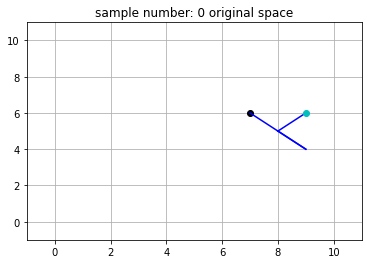

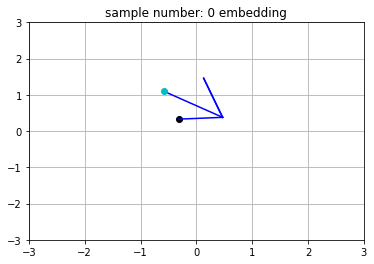

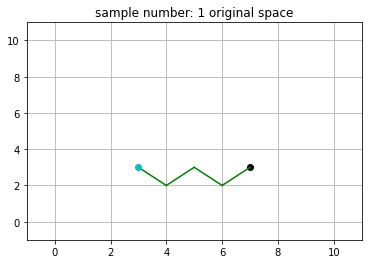

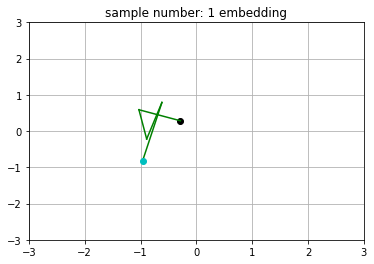

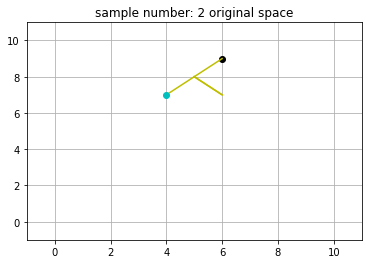

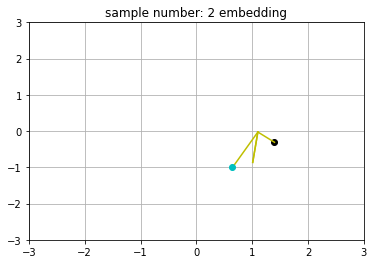

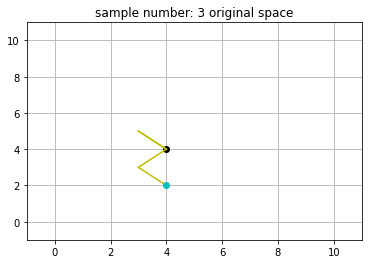

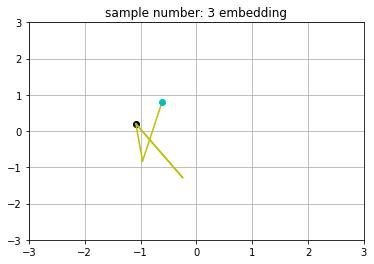

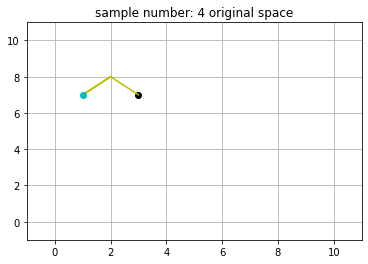

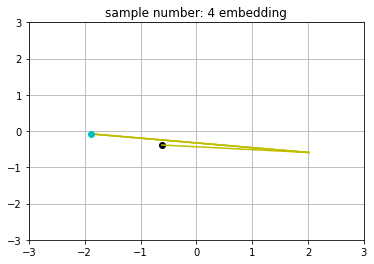

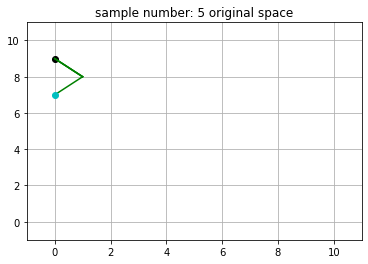

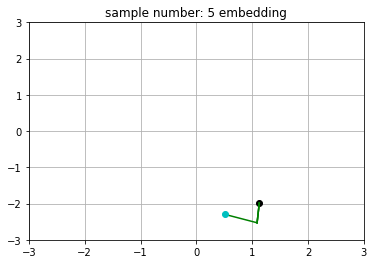

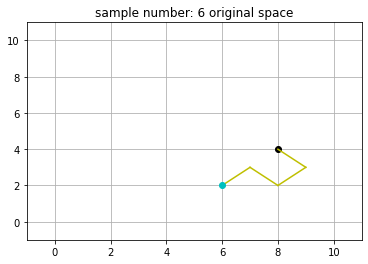

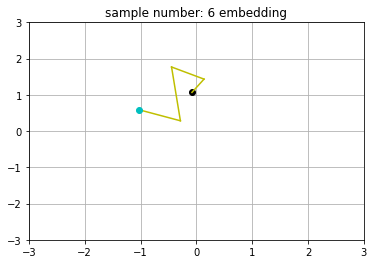

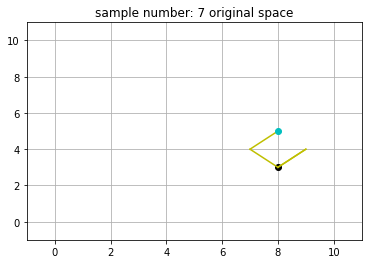

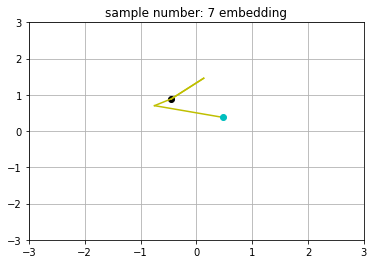

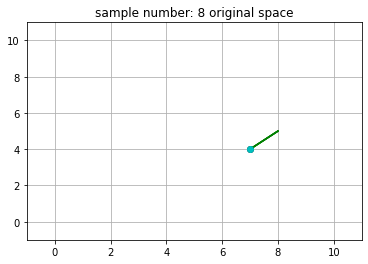

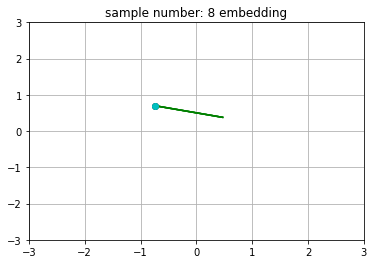

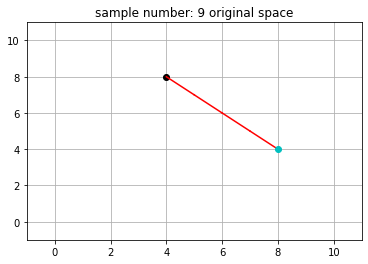

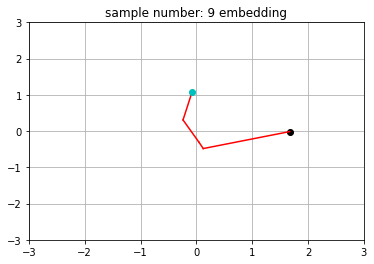

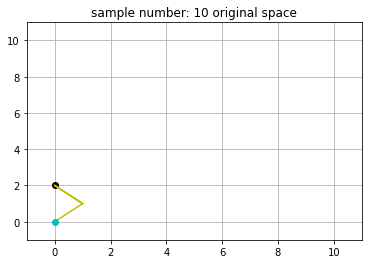

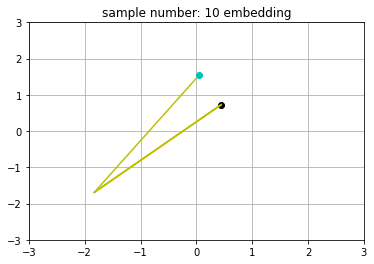

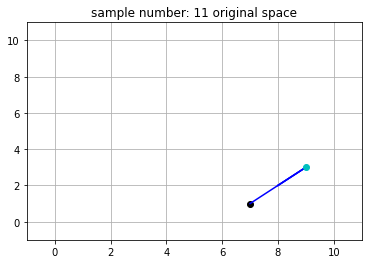

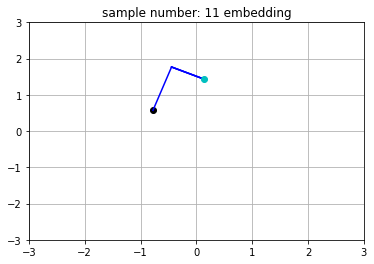

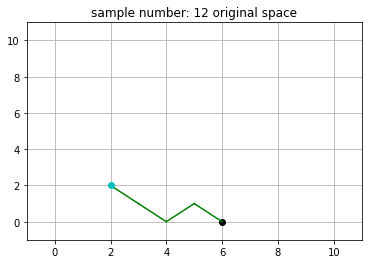

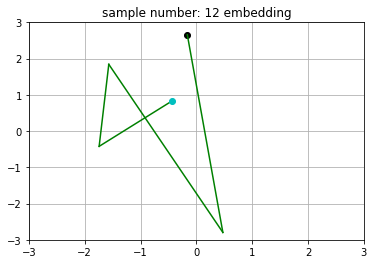

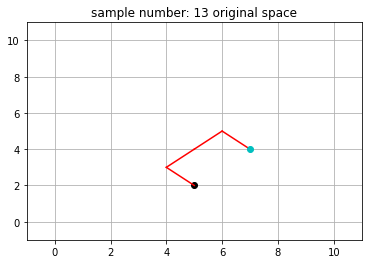

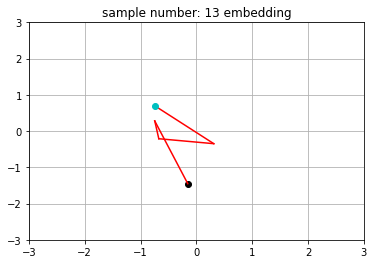

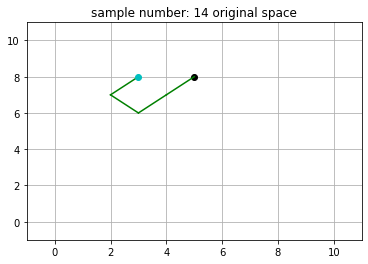

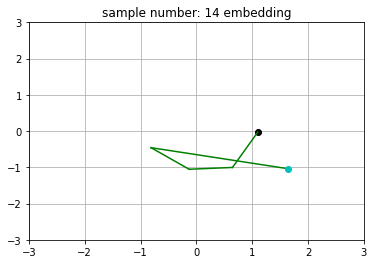

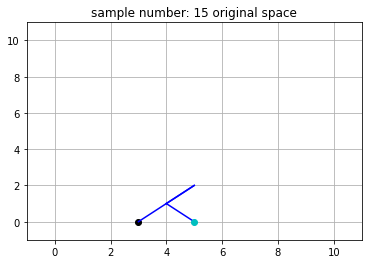

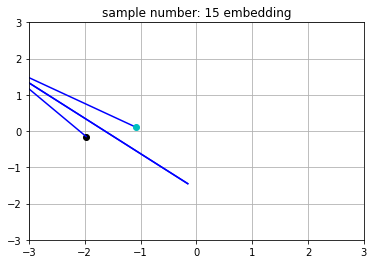

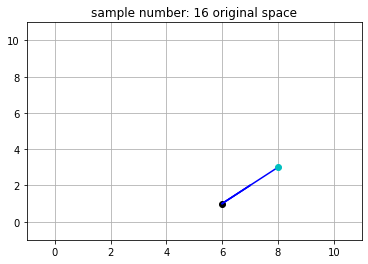

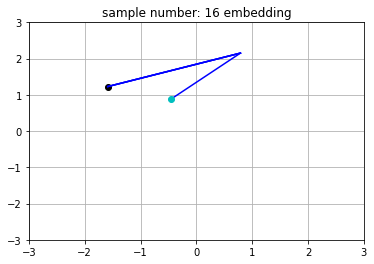

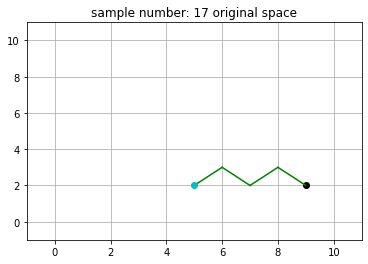

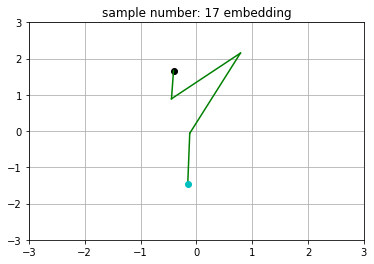

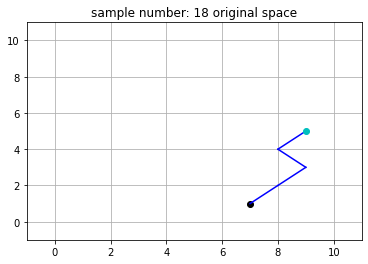

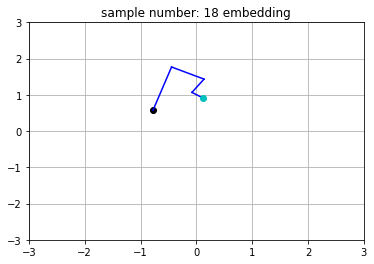

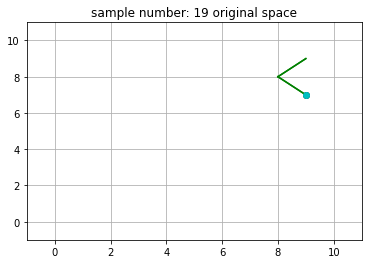

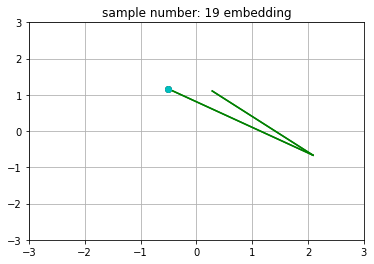

In [ ]:
numpy_paths = np.array([x.numpy() for x in visual_paths.cpu()])
numpy_paths = numpy_paths.astype('int') 
numpy_embeddings = np.array([x.detach().numpy() for x in embed_evolution])
final_embeddings = numpy_embeddings[-1]
numpy_labels = visual_labels.numpy()

for i in range (b_size):
  plt.title("sample number: " + str(i) +  " original space")
  axes = plt.gca()
  axes.set_xlim([-1,11])
  axes.set_ylim([-1,11])
  line = get_color(numpy_labels, i)

  plt.plot(np.floor_divide(numpy_paths[i][0], 10), numpy_paths[i][0] % 10, 'ko-')

  for j in range(4):
    plt.plot([np.floor_divide(numpy_paths[i][j], 10), np.floor_divide(numpy_paths[i][j+1], 10)], [numpy_paths[i][j] % 10, numpy_paths[i][j+1] % 10 ], line)

  plt.plot(np.floor_divide(numpy_paths[i][4], 10), numpy_paths[i][4] % 10, 'co-')
  plt.grid(True)
  plt.show()

  plt.title("sample number: " + str(i) + " embedding")
  axes = plt.gca()
  axes.set_xlim([-3,3])
  axes.set_ylim([-3,3])

  plt.plot(final_embeddings[i][0][0], final_embeddings[i][0][1], 'ko-')

  for j in range(4):
    plt.plot([final_embeddings[i][j][0], final_embeddings[i][j+1][0]], [final_embeddings[i][j][1], final_embeddings[i][j+1][1]], line)

  plt.plot(final_embeddings[i][4][0], final_embeddings[i][4][1], 'co-')
  plt.grid(True)
  plt.show()


This code shows that the structure of the embedding layer is different from original structure where possible inputs are placed in a grid.

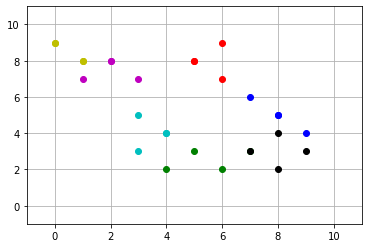

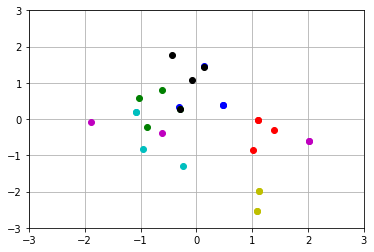

In [ ]:
def plot_n_points(n):
  axes = plt.gca()
  axes.set_xlim([-1,11])
  axes.set_ylim([-1,11])
  
  colors = ['bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko']

  for i in range(n):
    for j in range(4):
      plt.plot(np.floor_divide(numpy_paths[i][j], 10), numpy_paths[i][j] % 10, colors[i % 7])
  
  plt.grid(True)
  plt.show()

  axes = plt.gca()
  axes.set_xlim([-3,3])
  axes.set_ylim([-3,3])

  for i in range(n):
    for j in range(4):
      plt.plot(final_embeddings[i][j][0], final_embeddings[i][j][1], colors[i % 7])
  plt.grid(True)
  plt.show()

plot_n_points(7)

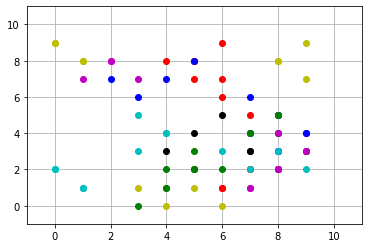

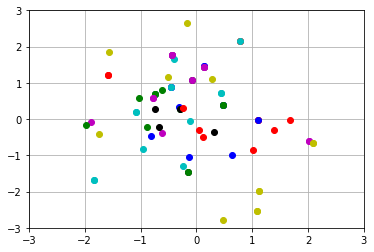

In [ ]:
plot_n_points(20)

In [ ]:
  axes = plt.gca()
  axes.set_xlim([-1,11])
  axes.set_ylim([-1,11])
  
  colors = ['bo', 'go', 'ro', 'co', 'mo', 'yo', 'ko']

  for i in range(20):
    plt.plot(np.floor_divide(numpy_paths[i][0], 10), numpy_paths[i][0] % 10, colors[i % 7])
  
  plt.grid(True)
  plt.show()

  axes = plt.gca()
  axes.set_xlim([-3,3])
  axes.set_ylim([-3,3])

  for i in range (20):
    plt.plot(final_embeddings[i][4][0], final_embeddings[i][4][1], colors[i % 7])
  plt.grid(True)
  plt.show()

The code below runs animation that shows how the embeddings of time series change during network training. As we can see the shape changes relatively slowly and the shape of the path is quite similar during training except for the moment in the middle when it changes drasticly. 

The size of embedding might be initially much different from the original embedding size, but it starts to remind original embedding size after half of the training process.

We can also see that the position of embedding is much different from the position of original path right from the begginig. It also seems that the embedding moves in a quite random direction during training.

To conclude, it seems like the classifier has more or less understanding of the concept of relative distance between points and it preserves it through ebedding (at least to some extend) but it does not preserve directions which means it produces its own interpretation of this concept.

Animation for 5 random paths in batch is shown but one can easily run other animations by passing another argument to animate_evaluation function.

In [ ]:
def animate_evolution(sample_num):
  fig, ax = plt.subplots()
  plt.close()
  fig.suptitle('Embedding evolution')

  ax.set_xlim((-3, 3))
  ax.set_ylim((-3, 3))

  line, = ax.plot([], [], lw=2)

  def init():
      line.set_data([], [])
      return (line,)

  def animate(i):
      line.set_color('k')
      line.set_data(numpy_embeddings[i,sample_num,:,0],numpy_embeddings[i,sample_num,:,1])
      return (line,)
    

  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=numpy_embeddings.shape[0], interval=1000, blit=True)
  rc('animation', html='jshtml')
  return anim

In [ ]:
animate_evolution(0)

In [ ]:
animate_evolution(7)

In [ ]:
animate_evolution(9)

In [ ]:
animate_evolution(1)

In [ ]:
animate_evolution(5)